In [123]:
import pandas as pd
import numpy as np
import pysd
import cmdstanpy # 2.30 is fastest (as of 08.12.2022) `cmdstanpy.install_cmdstan()` 
from cmdstanpy import CmdStanModel, cmdstan_path
#import arviz as az #!pip install git+https://github.com/arviz-devs/arviz
az.style.use("arviz-darkgrid")
import os
from IPython.display import Image
#import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# set your working directiory
os.chdir("/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts")

# Structuring Uncertainties in Dynamic Models: 
## Predator-Prey and Supply-Demand Dynamics with Bayesian Approach

Angie Moon, 07.2022


<a href = '##Three-source-of-uncertainties-in-dynamic-model'>Three source of uncertainties in dynamic model </a>

<a href = '##Predator-Prey:-parameter-and-measurement-uncertainty'>Predator-Prey: parameter and measurement uncertainty </a>

<a href = '#Data:-Lynx-and-Hare-Pelts-in-Canada'>Data: Lynx and Hare Pelts in Canada</a>

<a href = '#Mechanistic-Model:-The-Lotka-Volterra-Equations'>Mechanistic Model: The Lotka-Volterra Equations</a>

<a href = '#Statistical-Model:-Prior-Knowledge-and-Unexplained-Variation'>Statistical Model: Prior Knowledge and Unexplained Variation</a>

<a href = '#Coding-the-Model:-Stan-Program'>Computational Model: Stan Program</a>

<a href = '##Demand-Supply:-parameter-measurement-process-uncertainty'>Demand-Supply: parameter, measurement, process uncertainty </a>

<a href = '#Mechanistic-Model:-The-Lotka-Volterra-Equations'>Mechanistic Model: Little's law?</a>

<a href = '#Statistical-Model:-Prior-Knowledge-and-Unexplained-Variation'>Statistical Model: Prior Knowledge, Unexplained Variation, Amplified Variation </a>

<a href = '#Coding-the-Model:-Stan-Program'>Computational Model: Stan Program</a>

<a href = '#Conclusion:-What-are-the-Population-Dynamics?'>Conclusion</a>

<a href = '#Exercises-and-Extensions'>Exercises and Extensions</a>

## Three sources of uncertainty in dynamic model

Parameter, process, and measurement are three sources of uncertainty in dynamic model. Statistical inference that returns uncertainty interval is the main step for verifying/validating one's dynamic model and we first suggest Bayesian framework which empowers us to model parameter uncertainty. Second, we introduce specific mechansims to propagate each source of uncertainties so that synthetic data and inferred parameters conditional on the synthetic data are properly generated. We illustrate with two examples: first with prey-predator model which includes two uncertainties: parameter and measurement. Second, in the demand-supply example, we introduce two formulations with and without process uncertainty and thereby analyze its effect with the focus of its interaction with the other two.

The absence of process uncertainty in predator-prey model is understandable as we infer `arc_parameter`, not `node_parameter`. In the demand-supply example, however, we can infer `node_parameter`s for `demand rate`. The main difference of `arc_parameter` and `node_parameter` is the uniqueness of uncertainty source. `arc_parameter` is unique given the two nodes, but there can be multiple  `node_parameter`s given a node, which amplifies uncertainty. This additional uncertainty is parallel to $dB_t$ term of Brownian motion which is regarded as $\sqrt{dt}$. The example of the `arc_parameter` is `alpha`, `beta`, `gamma`, `delta` from the predator-prey model and `mu`, `sigma`, `rho` of the node `demand rate` from demand-supply model. `mu` and `sigma` are location and scale paramter and `rho` is autocorrelation parameter (which may be `dt-dependent`? ). 

Jair's vignette on comparing the state variable of three data generating processes, a) noraml random variable with fixed `mu` and `sigma` b) adding `rho` i.e. multiplying `pink noise` to a), c) geometric Brownian motion with `mu` and `sigma`, shows state value measured by `inventory` state remains the same across different `dt`s only for b) and c). If the purpose is to match the state values, scale parameter for a) should be adjusted proportional to $\sqrt{dt}$. However, it remains to be seen whether a) possess internal consistency for each resolution i.e. for each `dt`, would a) pass SBC when the same value is used for `dt` in integration (as part of generator) and `precision` in ODE solver (as part of inference)? If parameter's shape of uncertainty is preserved for each resolution, the author is willing to be not bothered by  state value's high sensitivity to `dt`. This is based on the belief that what we call "model" is in fact combination of statistical and computational model and it is natural that our inference is affected by the parameters of computational model. This is why both software and hardware specification are required for replication in computing. Unfortunately, sensitivity of hardware parameters (e.g. `precision` in ODE solver, `adapt delta` in HMC) are less tolerated than that of software (e.g. statistical model's parameter).

## Predator-Prey: parameter and measurement uncertainty

Predator-Prey population model by Lotka (1925) and Volterra (1926) are deterministic system dynamics model with two state variables (population of predator and prey), four flow variables (each of their birth and death), and four parameters (one for each flow variable). A statistical model learning parameter uncertainty and measurement uncertainty simultaneously is suggested which treats deterministic solutions of Lotka-Volterra equations as expected population sizes. To be specific, `p` number of constant parameter is replaced with its own prior distribution with prior paramters to model paramter uncertainty. Also, likelihood distribution and random error's scale parameter is added to represent measurement uncertainty. Stan, as both the language and and an optimizer, first encodes statistical model to be cast into optimization problem, then returns samples representing distribution that maximize the posterior via HMC. Data of Lynx and Hare population collected annually between 1900 and 1920 is used. 

For model checking, we run prior predictive check (PPC1) and simulation-based calibration (SBC) for verification then posterior predictive check (PPC) for validation. With parameter's posterior distribution that passed two checks, we use Bayesian forecasting system to propagate uncertainty to predictive distribution. The importance of the sequence (pre and post data) are discussed focusing on the different roles of sythetic (for PPC1, SBC) and real data (for PPC2). Posterior predictive check shows the model fits observed data well meaning full Bayesian approach can be used to estimate past and future's population.

Lastly, assuming another scenario where PPC2 failed and we illustrate model updating. Based on the new findings in the new SBC paper, calibration should be conditional on not only parameter distribution but also on observed data, we introduce rejection sampling. 

## Data: Lynx and Hare Pelts in Canada

The species of interest in this case study are

- hares: prey, an hervivorous cousin of rabbits, and
- lynxes: predator, a feline predator whose diet consists largely of hares.

Spikes in the lynx population lag those in the hare population. When populations are plotted against one another over time, the population dynamics orbit in an apparently stable pattern. Population oscillations can be modeled with a pair of differential equations similar to that used to describe springs. The first plot is the number of lynx and hare pelts (in thousands) collected for twenty years. The second plot is the phase plot of number of pelts collected for lynx versus hares similar to that of the dynamics of a spring in phase space (i.e., position vs. momentum).

[Text(0.5, 0, 'year'), Text(0, 0.5, 'pelt (thousands)')]

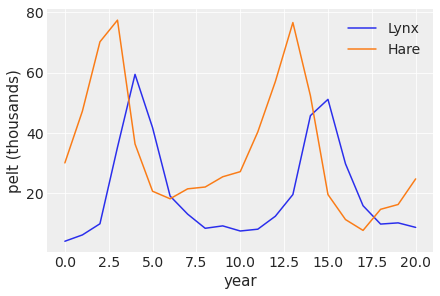

In [3]:
lynx_hare_df = pd.read_csv('data/hudson-bay-lynx-hare.csv')

# data viz
pd.melt(lynx_hare_df, id_vars = 'Year').iloc[[0,20,21,41]]
pd.melt(lynx_hare_df, id_vars = 'Year').iloc[[0,1,20,21,40,41]].rename(columns = {'variable':'species', 'value':'pelts in thousands'})
ax = lynx_hare_df.loc[:, ['Lynx', 'Hare']].plot()
ax.set(xlabel='year', ylabel='pelt (thousands)') 

Text(0, 0.5, 'hare pelts (thousands)')

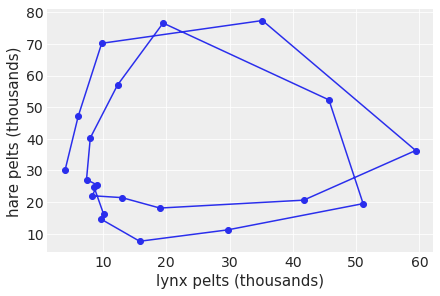

In [4]:
plt.scatter(lynx_hare_df.loc[:, 'Lynx'], lynx_hare_df.loc[:, 'Hare'])
plt.plot(lynx_hare_df.loc[:, 'Lynx'], lynx_hare_df.loc[:, 'Hare'])
plt.xlabel('lynx pelts (thousands)')
plt.ylabel('hare pelts (thousands)')

## Mechanistic Model: The Lotka-Volterra Equations

The Lotka-Volterra equations (Lotka 1925; Volterra 1926, 1927) are based on the assumptions that

- the predator population intrinsically shrinks,
- the prey population intrinsically grows,
- a larger prey population leads to a larger predator population, and
- a larger predator population leads to a smaller prey population.

More specifically, the rate of growth of the prey population is proportional to the size of the prey population, leading to exponential growth. The prey population simultaneously shrinks at a rate proportional to the size of the product of the prey and predator populations. For the predator species, the direction of growth is reversed. The predator population shrinks at a rate proportional to its size and grows at a rate proportional to the product of its size and the prey population’s size.

Together, these dynamics lead to a cycle of rising and falling populations. With a low lynx population, the hare population grows. As the hare population grows, it allows the lynx population to grow. Eventually, the lynx population is large enough to start cutting down on the hare population. That in turn puts downward pressure on the lynx population. The cycle then resumes from where it started.

The Lotka-Volterra equations (Volterra 1926, 1927; Lotka 1925) are a pair of first-order, ordinary differential equations (ODEs) describing the population dynamics of a pair of species, one predator and one prey[<sup>5</sup>](#fn5).

* u(t)≥0 is the population size of the prey species at time t, and
* v(t)≥0 is the population size of the predator species.

Volterra modeled the temporal dynamics of the two species (i.e., population sizes over times) in terms of four parameters, $\alpha, \beta, \gamma, \delta \geq 0$, as

$$
\begin{eqnarray}
\frac{\mathrm{d}}{\mathrm{d}t} u
& = &  (\alpha - \beta v) u
& = & \alpha u - \beta u v
\\[6pt]
\frac{\mathrm{d}}{\mathrm{d}t} v
& = &  (-\gamma + \delta \, u) \, v
& = & -\gamma v + \delta uv
\end{eqnarray}
$$

$u(t)$ and $v(t)$ are rendered as $u$ and $v$.  The factor $\alpha$, $\beta$ are the rate of birth and shrinkage relative to the product of the population sizes where as $\gamma$, $\delta$  are the shrinkage and growth rate as a factor of the product of the population sizes. Both u and v have positivitity constraints. as long as the initial populations are non-negative, i.e., $u(0) \geq 0$ and $v(0) \geq 0$, because the rate of change in each population is a factor of the population size itself.

 is the growth rate of the prey population, whereas 

### Four behaviors in the limit

One way to understand systems of equations is to consider their limiting behavior.  In this case, there are four behaviors.

1. If both population sizes are initially positive, the populations will oscillate in a fixed pattern indefinitely, remaining positive.
2. If both population sizes are initially zero, the population sizes will remain zero.
3. If the predator population size is zero and the prey population size positive, the predator population size remains zero and the prey population grows without bound.
4. If the predator population size is positive and the prey population size zero, the prey population size remains zero while the predator population shrinks toward zero size.

## Statistical Model: regreasion framing and uncertainty embedding

### Solving the inverse problem

For a given legal value of the model parameters and initial state,  the Lotka-Volterra model predicts population dynamics into the future (and into the past).  But given noisy data about population dynamics, how do we solve the inverse problem, that of inferring the values of model parameters consistent with the data?  The general approach in Bayesian statistics is somewhat counterintuitive, as it involves formulating the forward model then using general principles to solve the inverse problem.

Specifically, a Bayesian model requires a mathematical model of what we know about the parameters (i.e., a prior) and a model of what we know about the data generating process given the parameters (i.e., a sampling distribution (The choice of prior is no more or less “subjective” than the choice of sampling distribution—both are mathematical approximations to some process of interest and as such must be validated for utility)).
Mathematically, a prior density $p(\theta)$ over the sequence of parameters $\theta$ encapsulates our knowledge of the parameters before seeing the data.  A sampling distribution (The sampling distribution p(θ|y) is called a likelihood function when considered as a function L(θ) of the parameters θ for fixed data y), which may have a continuous, discrete or mixed probability function, $p(y | \theta)$ characterizes the distribution of observable data $y$ given parameters $\theta$.

Bayes's rule gives us a general solution to the inverse problem, expressing the posterior $p(\theta | y)$ in terms of the prior $p(\theta)$ and likelihood $p(y | \theta)$[<sup>10</sup>](#fn10).

Stan provides a form of Markov chain Monte Carlo (MCMC) sampling that draws a sample $\theta^{(1)}, \ldots, \theta^{(M)}$ from the posterior to use for computational inference. Posterior quantities of interest may be expressed as derived random variables using functions $f(\theta)$ of parameters. Such functions may be used for posterior expectation calculations such as parameter estimates that minimize expected square error when $f(\theta) = \theta$, or event probabilities such as the probability of the hare population falling below some fraction of the lynx population, when $f(\theta)$ is some indicator function. 

### Uncertainty embedding for forward-backward symmetry required for calibration

The Lotka-Volterra model is deterministic in that given the value of the system parameter and initial outcome state, equation solutions (simulated outcome value) are fully determined. However, for empirical research which use posterior inference from the real data as it final forecast, forward model should be re-designed. This is because symmetry of forward and backward model (i.e. data generation and its inference) is the theoretical justification of calibration. To pass this internal consistency test (or with enough resource, SBC which is rank-statistics based), we need the two process to be the mirror image of other. This is why we purposefully embed uncertainty components, waiting to be captured in the inference step. The purpose is to test resilience and identifiability of our models evidenced by the perfect retrival of prior distribution for every uncertainty we embedded. 

### Linear regression analogy

Like in a simple linear regression, we will proceed by treating the underlying determinstic model as providing an expected population value around which there will be variation due to both measurement error and simplifications in the scientific model. Consider the typical formulation of a linear regression, where $y_n$ is an observable scalar outcome, $x_n$ is a row vector of unmodeled predictors (aka covariates, features), $\beta$ is a coefficient vector parameter, and $\sigma > 0$ is the error scale,

$$
\begin{eqnarray}
y_n & = & x_n \beta + \epsilon_n
\\[6pt]
\epsilon_n & \sim & \mathsf{Normal}(0, \sigma)
\end{eqnarray}
$$

### Adding measurement uncertainty (epistemic)
Before embedding parameteric uncertainty, linear predictor $x_n \beta$ with predictor $x_n$ (row $n$ of the data matrix $x$) and coefficient (column) vector $\beta$ are deterministic. The only source of uncertainty is from the measurement. This is expressed by assigning a normal distribution to error term $\epsilon_n$. Equal expression is with latent error variable $\epsilon_n$ as follows[<sup>17</sup>](#fn17), 

$$
y_n \sim \mathsf{Normal}(x_n \beta, \sigma).
$$

### Adding parameter uncertainty (epistemic)
Next, we add parameter uncertainty by coding estimated parameter as a distribution rather than a fixed value. This distribution is called prior distribution and from our example, Normal distirbution is chosen to endow the uncertainty to the four estimated parameters $\alpha, \beta, \gamma, \delta$. Considering their role difference, $\alpha, \gamma$ as multipliers of $u, -v$ and $\beta, \delta$ as multipliers of $uv$, prior parameter are chosen as N(1, 0.5) and N(0.05, 0.05) for each. For this selection, refer to the original case study [Carpenter18](https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html).

### Adding aleatoric uncertainty
Lastly, initial population is added to the list of estimated parameter. Instant reason for this modeling decision is measurement noise; as population cannot be directly measured pelts (our data) are used as its noisy proxy). However, more fundamental reason is aletoric uncertainty, namely unmodeled uncertainty. There are factors that impact predator and prey population size other than the current population size. There are variable environmental effects, such as weather, which will vary from season to season and year to year and affect population sizes. Infectious diseases occasionally spread through a population, reducing its size (Hewitt 1921). There are also more long-term environmental factors such as carrying capacity (Carrying capacity is roughly the maximum population that an environment can sustain. It is often modeled in the system dynamics as an asymptote on population size.). However, our forward model is restricted to two differential equations involving two stock variables (`simulated outcome`) and four `estimated coefficient parameter`s (four flow variables can be expressed with the other two). Hence, after restricting the architecture, we are reaching out to the best version of ourselve by declaring the initial population as estimated parameter. In Stat/Machine learning terms, Stan optimization algorithm returns `estimated parameter` value that maximize log posterior among the feasible (restricted basis function) space defined by the modeler in the form of stock-parameter relationship.

Continuing on `simulated outcome` and `observed outcome` coflow, `observed outcome` can replace `simulated outcome` also known as state-resetting but we maintain the error term to compensate for measurement error and unexplained variation in the data (Challenge: check whether this is equivalent to the original text "Solutions to the Lotka-Volterra equations replace the linear predictor xnβ, but we maintain the error term to compensate for measurement error and unexplained variation in the data."). In the case of population dynamics, the data $y_n$ consists of measurements of the prey $y_{n, 1}$ and predator $y_{n, 2}$ populations at times $t_n$[<sup>18</sup>](#fn18).

The true population sizes at time $t = 0$ are unknown---we only have measurements $y^{\rm init}_1$ and $y^{\rm init}_2$ of them. The true initial population sizes at time $t = 0$ will be represented by a parameter $z^{\mathrm init}$, so that

$$
\begin{array}{rcl}
z^{\mathrm init}_1 & = & u(t = 0)
\\[4pt]
z^{\mathrm init}_2 & = & v(t = 0).
\end{array}
$$

Next, let $z_1, \ldots, z_N$ be the solutions to the Lotka-Volterra differential equations at times $t_1, \ldots, t_N$ given initial conditions $z(t = 0) = z^{\mathrm init}$ and parameters $\theta = (\alpha, \beta, \gamma, \delta)$. Each $z_n$ is a pair of prey and predator population sizes at the specified times,

$$
\begin{array}{rcl}
z_{n, 1} & = & u(t_n)
\\[4pt]
z_{n, 2} & = &  v(t_n).
\end{array}
$$

The $z_n$ are random variables, but they are deterministic functions of the random variables for the initial state $z^{\mathrm init}$ and system parameters $\alpha, \beta, \gamma, \delta$.

The observed data is in the form of measurements $y^{\rm init}$ of the initial population of prey and predators, and subsequent measurements $y_n$ of the populations at times $t_n$, where $y^{\mathrm init}$ and the $y_n$ consist of a pair of measured population sizes, for the prey and predator species.

In summary, the measurements, $y^{\rm init}$ and $y_n$, are drawn indepently from a normal distribution centered at the underlying population sizes, $z^{\rm init}$ and $z_n$, with noise scales $\sigma$.


<span id="fn10">10 Bayes's rule for parameters $\theta$ and observed data $y$ is $$ \begin{array}{rcl} p(\theta\,|\, y) & = & \displaystyle \frac{p(\theta, y)}{p(y)} \\[4pt] & = & \displaystyle \frac{p(y | \theta) \, p(\theta)}{p(y)} \\[4pt] & = & \displaystyle \frac{p(y | \theta) \, p(\theta)}{\int_{\Theta} p(y | \theta) \, p(\theta) \, \mathrm{d}\theta} \\[4pt] & \propto & p(y | \theta) \, p(\theta). \end{array} $$</span>

<span id="fn11">11 The matrix of $\theta^{(m)}$ values (parameter by draw) is what is returned by Stan.</span>

<span id="fn12">12 The convergence result (as well as error bounds) follows from the MCMC central limit theorem when $\theta^{(m)}$ are drawn according to $p(\theta | y)$ with an appropriate MCMC algorithm,  
$$ \begin{array}{rcl} \displaystyle \mathbb{E}[ \, f(\theta) \mid y \, ] & = & \int_{\Theta} \, f(\theta) \, p(\theta | y) \, \mathrm{d}\theta \\[4pt] & = & \lim_{M \rightarrow \infty} \, \frac{1}{M} \sum_{m=1}^M \, f\!\left(\theta^{(m)}\right) \\[4pt] & \approx & \frac{1}{M} \sum_{m=1}^M \, f\!\left(\theta^{(m)}\right) \ \ \mbox{ for some finite } M \end{array} $$</span>


<span id="fn16">16 Gauss initially noted that the maximum likelihood estimate derived from the normal error model is identical to the least square error estimate derived by minimizing the sum of squared errors, $ϵ^⊤ϵ$. With Markov, Gauss further proved that it was the lowest variance unbiased estimator.</span>

<span id="fn17">17 The latent error variable may be defined in terms of x, y, and $β$as
$ϵ_n=y_n−x_nβ$.</span>
    
<span id="fn18">18 This model makes the assumption that the underlying population sizes $z_{n,k}$ and measurements of it $y_{n,k}$ are continuous. This is a very tight approximation to counts when the numbers are in the thousands.</span>

### Multiplicative error and the lognormal distribution

It is common to log transform positive-only parameters so that they are no longer constrained to be positive.  On the log scale, we can then take the error to be unconstrained and additive, just as in linear regression.

$$
\begin{eqnarray}
\log y_{n, k} & = & \log z_{n, k} + \epsilon_{n, k}
\\[6pt]
\epsilon_{n, k} & \sim & \mathsf{Normal}(0, \sigma_k)
\end{eqnarray}
$$

where the $z_n$ are the solutions to the Lotka-Volterra equations at times $t_1, \ldots, t_N$ given initial populations $z^{\mathrm init}$.  The prey and predator populations have error scales (on the log scale) of $\sigma_1$ and $\sigma_2$.

With additive errors on the log transformed scales, the result of transforming back to the natural scale (by exponentiation) leads to multiplicative errors.

$$
y_{n, k} \sim \mathsf{LogNormal}(z_{n, k}, \sigma_n).
$$
whenever
$$
\log y_{n, k} \sim \mathsf{Normal}(\log z_{n, k}, \sigma_n).
$$
The $\mathsf{LogNormal}$ density accounts for the non-linear change of variables through a Jacobian adjustment (The [Stan manual chapter on changes of variables](https://mc-stan.org/docs/2_23/stan-users-guide/changes-of-variables.html) works through the Jacobian adjustment for this particular change of variables.).

## Translating the Model for Generation: pysd Program

Code is auto-translated using pysd. Initial conditions such as the lenghth of simulation and `assumed parameter` are explicitly set. Prey-predator model doesn't have any `assumed parameter`. 

Having set the four `estimated parameter`'s prior as N(1, 0.5) and N(0.05, 0.05), we set `alpha`, `gamma` as 1 and `beta`, `delta` as 0.05. Comparing to the observed states, simpled version of prior predictive check is not too bad. Full version of prior predictive check is much easier once the model is coded with Stan, hence will be revisited after. For calibration purpose, we use generated data for the next inference step. 

In [5]:
mod = pysd.read_vensim('vensim_models/prey-predator.mdl')
# list(mod.doc[mod.doc['Type']=="Stateful"].iloc[:,1]) # ['predator', 'prey']
assumeall_res = mod.run(initial_condition=(0, {'predator':lynx_hare_df.loc[:, 'Lynx'][0], 'prey': lynx_hare_df.loc[:, 'Hare'][0]}),
        params={'alpha': 1, 'gamma': 1, 'beta': 0.05, 'delta': 0.05},
        return_timestamps = range(lynx_hare_df.shape[0]))
state_dt = assumeall_res.loc[:, ('Predator', 'Prey')]

Default time_step is supplied from the vensim model which is .03125 here but can be changed if different precision is needed. We aim our model to be on continuous time (as opposed to discrete time). Whether the time step is small enough can be heuristically checked by comparing the value of state variables for the given time_step and its halved version.

In [6]:
dt = (assumeall_res.loc[0, 'TIME STEP'])
dt

0.03125

From comparison below, we judge time_step as .03125 is small enough to be considered as continuous time.

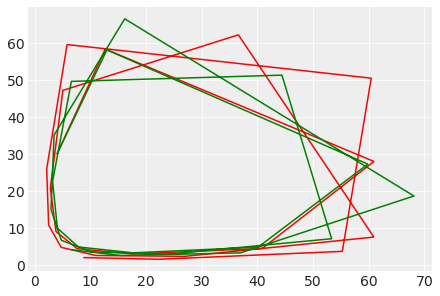

In [7]:
assumeall_res_halfdt = mod.run(initial_condition=(0, {'predator':lynx_hare_df.loc[:, 'Lynx'][0], 'prey': lynx_hare_df.loc[:, 'Hare'][0]}),
        params={'alpha': 1, 'gamma': 1, 'beta': 0.05, 'delta': 0.05},
        time_step=dt/2,
        return_timestamps = range(lynx_hare_df.shape[0]))

state_halfdt = pd.DataFrame(assumeall_res_halfdt.loc[:, ('Predator', 'Prey')]) #, columns = ['h_Predator', 'h_Prey'])
state_halfdt.rename(columns = {"Predator": "h_Predator", "Prey": "h_Prey"}, inplace = True)

comp_dt = pd.concat([state_dt, state_halfdt], axis = 1)
#plt.plot(comp_dt)
plt.plot(state_dt.loc[:, 'Predator'], state_dt.loc[:, 'Prey'], color='r')
plt.plot(state_halfdt.loc[:, 'h_Predator'], state_halfdt.loc[:, 'h_Prey'], color = 'g')

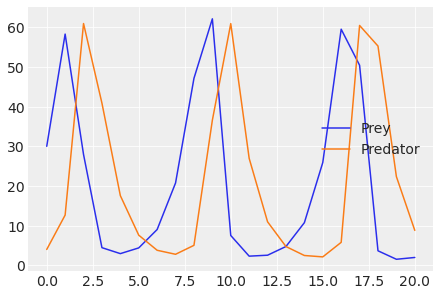

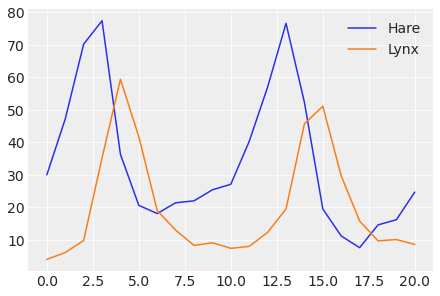

In [8]:
assumeall_res.loc[:, ['Prey', 'Predator']].plot()
lynx_hare_df.loc[:, ('Hare', 'Lynx')].plot()
prey_pred_df = assumeall_res.loc[:, ['Prey', 'Predator']]

## Translating the Model for Inference: Stan Program

Using `stan_builder` in pysd (in process), Stan code is generated. User input is `time`, `estimated parameter`, `observed state`. Code is auto-translated using pysd. Initial conditions such as the lenghth of simulation and `assumed parameter` are explicitly set. Prey-predator model doesn't have any `assumed parameter`. 

Having set the four `estimated parameter`'s prior as N(1, 0.5) and N(0.05, 0.05), we set `alpha`, `gamma` as 1 and `beta`, `delta` as 0.05. Comparing to the observed states, simpled version of prior predictive check is not too bad. Full version of prior predictive check is much easier once the model is coded with Stan, hence will be revisited after.

To compose one stanfile which consists of six blocks (data, transformed data, parameter, transformed parameter, model, generated quantities), users should input three priors: relational, variational, demand. The table below expresses each prior's mathematical identity and location within the program.

| -          | `demand_prior()`     | `relational_prior()` | `variation_prior()`        |  
| ---------- | -------------------- | ------------------ | ------------------------ | 
| type       | objective function   | set of equalities  | probability distribution | 
| Stan block | generated quantities | function           | model                    | 

In [165]:
from pysd.translators.vensim.vensim_file import VensimFile
from pysd.translators.xmile.xmile_file import XmileFile
from pysd.builders.stan.stan_model_builder import *

vf = VensimFile("vensim_models/prey-predator.mdl")

vf.parse()

am = vf.get_abstract_model()
stan_function_builder = StanFunctionBuilder(am) 
prey_pred_relational = stan_function_builder.build_function_block(["alpha", "beta", "gamma", "delta"], ["prey", "predator"], function_name = "vensim_func")

stan_file_path = os.path.join(os.getcwd(), "stan_file", "prey_pred_relational.stan")
with open(stan_file_path, "w") as f:
    print(prey_pred_relational, file=f)

# TODO should remove `functions{}` manually (issue 6)

## Draws2Data

In [127]:
sf_path_draws2data = os.path.join(os.getcwd(), "stan_file", "pp_draws2data.stan")
sm_draws2data = CmdStanModel(stan_file = sf_path_draws2data)

N = lynx_hare_df.shape[0] - 1
times = np.arange(1, N + 1)

data_draws2data = {
    "N": N,
    "times": times
}
fit_prior_pred = sm_draws2data.sample(data=data_draws2data, iter_sampling=30, chains=1, fixed_param=True, iter_warmup=0)

10:00:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

10:00:45 - cmdstanpy - INFO - CmdStan done processing.


We first plot first ten sampled (out of 4,000) trajactories and briefly check the range are not too extreme. As can be seen from the figure, blue and orange real prey and predator are comparable to its prior predictive corrspondance (green and plum).

We have real data as an external reference so as long as the predicted ranges are not too off, we give a pass to prior predictive check. Summary statistics such as N^th moments can be used for comparison. Few comments:

a. we use real data below as a representation of our knowledge, so prior predictive check is not double dipping (using data twice)

b. Bayesian prior corresponds to frequentist's regularization so having a tighter prior than posterior is not unnatrual; simply our determination to find a model concentrated around certain model configuration

c. if tight prior is well-placed, it prevents diveregence from frustrating geometry and boosts sampling efficiency

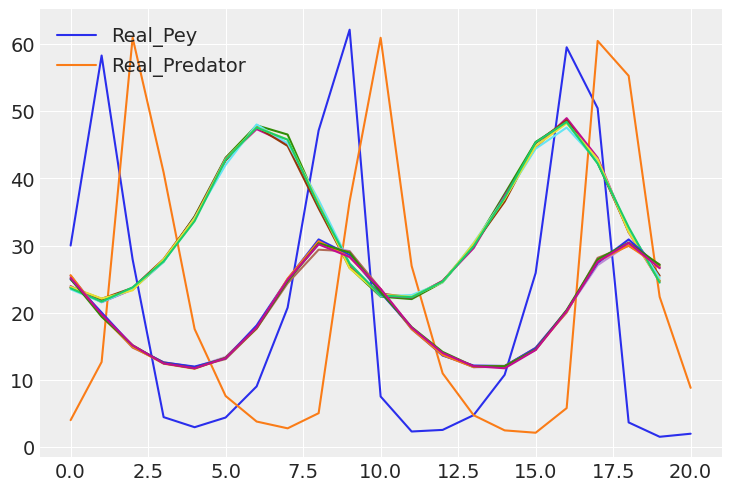

In [128]:
fig, ax = plt.subplots()
#compare with real 
ax.plot(state_dt.loc[:, ['Prey']], label = "Real_Pey")
ax.plot(state_dt.loc[:, ['Predator']], label = "Real_Predator")
ax.plot(pd.DataFrame(sm_prior.y_tilde[:,:,0]).T.loc[:, :5])
ax.plot(pd.DataFrame(sm_prior.y_tilde[:,:,1]).T.loc[:, :5])
ax.legend()

## Data2Draws

In [33]:
sf_path_data2draws = os.path.join(os.getcwd(), "stan_file", "pp_data2draws.stan")
sm_data2draws = CmdStanModel(stan_file = sf_path_data2draws)
N = lynx_hare_df.shape[0] - 1
times = np.arange(1, N + 1)
y_init = prey_pred_df.loc[0, ['Prey', 'Predator']]
y = prey_pred_df.loc[1:, ['Prey', 'Predator']]

data_data2draws = {
    "N": N,
    "times": times,
    "y_init": list(y_init),
    "y": y.values.tolist(),
}
fit_posterior_draws = sm_data2draws.sample(data = data_data2draws, iter_sampling = 400, chains = 2, show_console = True, seed = 1234)

15:52:37 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/pp_data2draws.stan to exe file /Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/pp_data2draws
15:52:49 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/pp_data2draws
15:52:49 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
15:52:49 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file --o=/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/pp_data2draws.hpp /Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/pp_data2draws.stan
Warning in '/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/pp_data2draws.stan', line 10, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead us

Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 400
Chain [1] num_warmup = 1000 (Default)
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /var/folders/4j/8mx5dnzd1p34_5y5r19b4g5m0000gn/T/tmprr2akp_3/z6cbxpi_.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] s

15:52:59 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] Iteration: 1400 / 1400 [100%]  (Sampling)
Chain [1] 
Chain [1] Elapsed Time: 2.635 seconds (Warm-up)
Chain [1] 0.856 seconds (Sampling)
Chain [1] 3.491 seconds (Total)
Chain [1] 
Chain [1] 
Chain [2] Iteration:  100 / 1400 [  7%]  (Warmup)
Chain [2] Iteration:  200 / 1400 [ 14%]  (Warmup)
Chain [2] Iteration:  300 / 1400 [ 21%]  (Warmup)
Chain [2] Iteration:  400 / 1400 [ 28%]  (Warmup)
Chain [2] Iteration:  500 / 1400 [ 35%]  (Warmup)
Chain [2] Iteration:  600 / 1400 [ 42%]  (Warmup)
Chain [2] Iteration:  700 / 1400 [ 50%]  (Warmup)
Chain [2] Iteration:  800 / 1400 [ 57%]  (Warmup)
Chain [2] Iteration:  900 / 1400 [ 64%]  (Warmup)
Chain [2] Iteration: 1000 / 1400 [ 71%]  (Warmup)
Chain [2] Iteration: 1001 / 1400 [ 71%]  (Sampling)
Chain [2] Iteration: 1100 / 1400 [ 78%]  (Sampling)
Chain [2] Iteration: 1200 / 1400 [ 85%]  (Sampling)
Chain [2] Iteration: 1300 / 1400 [ 92%]  (Sampling)
Chain [2] Iteration: 1400 / 1400 [100%]  (Sampling)


16:09:38 - cmdstanpy - INFO - Chain [2] done processing
16:09:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: ode_rk45: initial state[1] is inf, but must be finite! (in '/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/pp_data2draws.stan', line 24, column 5 to line 26, column 47)
	Exception: ode_rk45: initial state[1] is inf, but must be finite! (in '/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/pp_data2draws.stan', line 24, column 5 to line 26, column 47)
	Exception: ode_rk45: initial state[1] is inf, but must be finite! (in '/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/pp_data2draws.stan', line 24, column 5 to line 26, column 47)
	Exception: ode_rk45: ode parameters and data is inf, but must be finite! (in '/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/pp_data2draws.stan', line 24, column 5 to line 26, column 47)
	Exception: pp_data2draws_model_namespace::log_prob: integrated_result[1][1] is nan, but

Chain [2] 
Chain [2] Elapsed Time: 717.22 seconds (Warm-up)
Chain [2] 291.561 seconds (Sampling)
Chain [2] 1008.78 seconds (Total)
Chain [2] 
Chain [2] 


"Exception: ode_rk45: initial state[1] is inf" may be because ode integrator is stiff; which may be resolved by using ode_bdf from [this](https://discourse.mc-stan.org/t/exception-integrate-ode-rk45-parameter-vector-1-is-inf-but-must-be-finite/13953/2?u=hyunji.moon) post.

## Inference Data

In [152]:
lynx_hare_df.loc[:, "Lynx"]

0      4.0
1      6.1
2      9.8
3     35.2
4     59.4
5     41.7
6     19.0
7     13.0
8      8.3
9      9.1
10     7.4
11     8.0
12    12.3
13    19.5
14    45.7
15    51.1
16    29.7
17    15.8
18     9.7
19    10.1
20     8.6
Name: Lynx, dtype: float64

In [150]:
lynx_hare_df.loc[:, ("Lynx","Hare")]

InvalidIndexError: (slice(None, None, None), 1)

In [160]:
# # stan_data = az.from_pystan(
# #     posterior=fit,
# #     posterior_predictive="y_hat",
# #     observed_data=["y"],
# #     log_likelihood={"y": "log_lik"},
# #     coords={"school": np.arange(eight_school_data["J"])},
# #     dims={
# #         "theta": ["school"],
# #         "y": ["school"],
# #         "log_lik": ["school"],
# #         "y_hat": ["school"],
# #         "theta_tilde": ["school"],
# #     },
# # )
# # data = az.load_arviz_data("non_centered_eight")
# # az.plot_ppc(data, data_pairs={"obs": "obs"}, alpha=0.03, figsize=(12, 6), textsize=14)
# # plt.show()
idata = az.from_cmdstanpy(
    posterior=fit_posterior_draws, 
    posterior_predictive=["y_hat"], 
    log_likelihood= ["log_lik"],
    observed_data = {"y_hat": lynx_hare_df.loc[:, ("Hare", "Lynx")]}
#    dtypes={"y_rep": int} if Poisson family
)

In [161]:
az.loo(idata)

Computed from 800 posterior samples and 20 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -644.91    36.16
p_loo      469.16        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       20  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

<AxesSubplot:xlabel='y_hat / y_hat'>

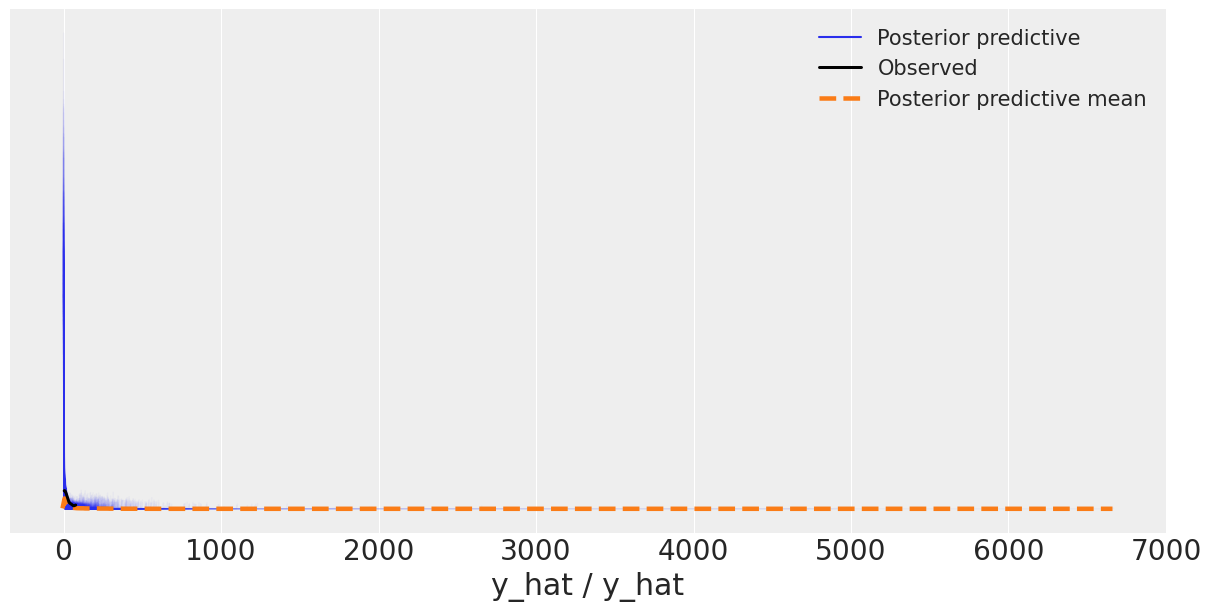

In [163]:
az.plot_ppc(idata, alpha=0.03, figsize=(12, 6),l)

In [129]:
fit_posterior_draws = posterior_draws

In [125]:
dims = {"y": ["N"], "x": ["N"], "log_likelihood": ["N"], "observed_data": ["N"], "y_hat": ["N"]}
idata_kwargs = {
    "posterior_predictive": ["y_hat"],
    "log_likelihood": "log_lik",
    "observed_data": ["y"],
    "dims": dims,
}
#idata = az.from_pystan(posterior=fit, posterior_model=sm, **idata_kwargs)
idata = az.from_cmdstanpy(
#    prior=prior_pred,
    posterior=fit_posterior_draws,
    prior_predictive= ["y_tilde"],
    posterior_predictive= ["y_hat"],
    log_likelihood: "log_lik",
    observed_data= "y",
    # dtypes={"y_rep": int} (if poisson dist)
)
    #predictions=["slack_comments_pred", "github_commits_pred"],
    #predictions_constant_data=["time_since_joined_pred"],
    #coords={"developer": names, "candidate developer" : candidate_devs},


SyntaxError: positional argument follows keyword argument (3705576184.py, line 14)

In [116]:
dims = {"y": ["N"], "x": ["N"], "log_likelihood": ["N"], "observed_data": ["N"], "y_hat": ["N"]}
idata_kwargs = {
    "posterior_predictive": ["y_hat"],
    "log_likelihood": "log_lik",
    "observed_data": ["y"],
    "dims": dims,
}
#idata = az.from_pystan(posterior=fit, posterior_model=sm, **idata_kwargs)
idata_stan = az.from_cmdstanpy(
#    prior=prior_pred,
    posterior=posterior_draws,
#    prior_predictive= "y_tilde",
    #posterior_predictive= "y_hat",
    observed_data= "
    **idata_kwargs
)
    #predictions=["slack_comments_pred", "github_commits_pred"],
    #predictions_constant_data=["time_since_joined_pred"],
    #coords={"developer": names, "candidate developer" : candidate_devs},


AttributeError: 'list' object has no attribute 'items'

In [117]:
az.loo(idata_stan, pointwise = True)

Computed from 800 posterior samples and 20 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -644.91    36.16
p_loo      469.16        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       20  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [112]:
arviz.plot_ppc(idata_stan)

KeyError: 'var names: "[\'y\'] are not present" in dataset'

In [83]:
a = {"Prey": prior_pred.y_tilde[:,:,0], "Predator": prior_pred.y_tilde[:,:,1]},

In [93]:
dims = {"y": ["time"], "x": ["time"], "log_likelihood": ["time"], "y_hat": ["time"]}
    
idata_kwargs = {
    "posterior_predictive": ["y_hat"],
    "observed_data": "y",
#    "constant_data": "x",
    "log_likelihood": ["log_lik"],
    "dims": dims,
}
idata_stan = az.from_cmdstanpy(
    prior=prior_pred,
    posterior=posterior_draws,
    prior_predictive= "y_tilde",
    #posterior_predictive= {'Prey': posterior_draws.y_hat[:,:,0], 'Predator': posterior_draws.y_hat[:,:,1]},
#    observed_data= "
    log_likelihood={
        'log_lik': posterior_draws.log_lik
    },
    #predictions=["slack_comments_pred", "github_commits_pred"],
    #predictions_constant_data=["time_since_joined_pred"],
    #coords={"developer": names, "candidate developer" : candidate_devs},
)

TypeError: unhashable type: 'numpy.ndarray'

In [81]:
idata_stan = az.from_cmdstanpy(
    prior=prior_pred,
    posterior=posterior_draws,
    prior_predictive= {"Prey": prior_pred.y_tilde[:,:,0], "Predator": prior_pred.y_tilde[:,:,1]},
    #posterior_predictive= {'Prey': posterior_draws.y_hat[:,:,0], 'Predator': posterior_draws.y_hat[:,:,1]},
    observed_data={'Prey': np.array(data_data2draws['y'])[:, 0], 'Predator' : np.array(data_data2draws['y'])[:, 1]},
    log_likelihood={
        'log_lik': posterior_draws.log_lik
    },
    #predictions=["slack_comments_pred", "github_commits_pred"],
    #predictions_constant_data=["time_since_joined_pred"],
    #coords={"developer": names, "candidate developer" : candidate_devs},
    # dims={
    #     "slack_comments": ["developer"],
    #     "github_commits" : ["developer"],
    #     "slack_comments_hat": ["developer"],
    #     "github_commits_hat": ["developer"],
    #     "time_since_joined": ["developer"],
    #     "slack_comments_pred" : ["candidate developer"],
    #     "github_commits_pred" : ["candidate developer"],
    #     "time_since_joined_pred" : ["candidate developer"],
    # }
)

TypeError: unhashable type: 'numpy.ndarray'

In [66]:
import arviz
arviz.plot_ppc(idata_stan)

KeyError: 'var names: "[\'Prey\' \'Predator\'] are not present" in dataset'

### Posterior Predictive checks based on estimation

In [ ]:
fit_draws2data = stan_model_draws2data.generate_quantities(data=data_draws2data, mcmc_sample=fit)

The output displayed in `xarray` format shows full information of how posterior is approximated conditional on user's input specified in U3 and U4. draws posterior approximation such as `method_variables()` which are parameters for the optimization algorithm. Although users unknowingly (sometimes intentionally) use default settings of default value of `method_variables()` (a.k.a hyperparameters in machine learning, and sometimes looked down upon as "nuts and bolts"), they affect the sample more than we know. Just as sensitivity checks w.r.t. different parameter values are recommended for SD models, variability of `method_varibles()` can also compared with outcome. However, estimation being computationally heavier than data generation, not much literature as far as the author know address this problem seriously with the exception of recent paper on deciding good enough posterior approximator after comparing the output from different precisions. [An importance sampling approach for reliable and eﬃcient inference in Bayesian ordinary diﬀerential equation models](https://arxiv.org/abs/2205.09059).

With `draws_xr()`, clicking the disk icon would show specific value of each row. Specific value of Stan's sample values can be further inspected with `summary()` function. 

In [ ]:
fit.draws_xr()

In [ ]:
fit.method_variables()

In [ ]:
fit.summary().round(decimals=3).iloc[1:10,:]

## Code


In [ ]:
print(stan_model_draws2data.code())

In [ ]:
print(stan_model_data2draws.code())

We recommend users to use positive instances of `divergences` and `iterations at max_treedepth` as potential signs of sampler's failure to explore the entire posterior. `divergences` counts when hamiltonian at each iteration is not preserved; `iterations at max_treedepth` means the number of post-warmup iterations which hit the maximum allowed treedepth before the trajectory hits “U-turn” condition of HMC-NUTS algorithm. Both can result in biased sample.

Small data makes the geometry of posterior distribution highly curved, thus the sampler may encounter difficulty in exploring the posterior space hence fail to fit the model. Increasing synthetic data by varying parameter values can be a potential solution.

In [ ]:
print(f'divergences:\n{fit.divergences}\niterations at max_treedepth:\n{fit.max_treedepths}')

for 
alpha =  np.random.normal(1, .5, 10)
beta =  np.random.normal(.05, .05, 10)
gamma =  np.random.normal(1, .5, 10)
delta =  np.random.normal(.05, .05, 10)
assumeall_res = mod.run(initial_condition=(0, {'predator':lynx_hare_df.loc[:, 'Lynx'][0], 'prey': lynx_hare_df.loc[:, 'Hare'][0]}),
        params={'alpha': 1, 'gamma': 1, 'beta': 0.05, 'delta': 0.05},
        return_timestamps = range(lynx_hare_df.shape[0]))

In [ ]:
fit.method_variables()


There were no divergent transitions[<sup>27</sup>](#fn27) reported.  The $\hat{R}$ values are all near 1, which is consistent with convergence.  The effective sample size estimates for each parameter are sufficient for inference.[<sup>28</sup>](#fn28) Thus we have reason to trust that Stan has produced an adequate approximation of the posterior.


<span id="fn27">27 Divergences occur when Stan’s Hamiltonian solver diverges from the true Hamiltonian, which must be conserved, because of numerical problems in the stepwise gradient-based approximation of the curvature of the log density.</span>

<span id="fn28">28 With effective sample sizes of roughly one thousand, standard errors are roughly one thirtieth the size of posterior standard deviations, being in an inverse square root relation.</span>

# Angie 0731 ends here


## Comparing the fitted model to data

Using a non-statistically motivated error term and optimization, Howard (2009, Figure 2.10) provides the following point estimates for the model parameters based on the data.
$$
\alpha^* = 0.55, \ \
\beta^* = 0.028, \ \
\gamma^* = 0.84, \ \
\delta^* = 0.026
$$

Our model produced the following point estimates based on the posterior mean,[<sup>29</sup>](#fn29)

$$
\hat{\alpha} = 0.55, \ \
\hat{\beta} = 0.028, \ \
\hat{\gamma} = 0.80, \ \
\hat{\delta} = 0.024,
$$

which are very close to Howard's estimates. [<sup>30</sup>](#fn30) The posterior intervals, which are quite wide here, may be interpreted probabilistically,

$$
\begin{array}{ccc}
\mbox{Pr}[0.47 \leq \alpha \leq 0.63] & = & 0.8
\\[4pt]
\mbox{Pr}[0.23 \leq \beta \leq 0.33] & = & 0.8
\\[4pt]
\mbox{Pr}[0.69 \leq \delta \leq 0.91] & = & 0.8
\\[4pt]
\mbox{Pr}[0.020 \leq \gamma \leq 0.029] & = & 0.8
\end{array}
$$
The effect of these estimates is plotted later with simulated population orbits.

Error scales for both populations have the same posterior mean estimate,

$$
\hat{\sigma}_1 \ = \ \hat{\sigma}_2 \ = \ 0.25.
$$

and both have the same posterior 80% interval, (0.20, 0.31).[<sup>31</sup>](#fn31) 

## Inference for population sizes

One inference we would like to make from our data is the size of the lynx and hare populations over time. Technically, we can only estimate the expected sizes of future pelt collections and must assume the population is somehow directly related to the numbers of pelts collected.  Howard (2009) plugs in optimization-derived point estimates to derive population predictions.

Rather than plugging in point estimates to get point predictions, we will follow the fully Bayesian approach of adjusting for uncertainty.  This uncertainty takes two forms in inference.  First, there is estimation uncertainty, which is fully characterized by the joint posterior density $p(\alpha, \beta, \gamma, \delta, z^{\mathrm init}, \sigma \mid y)$.[<sup>32</sup>](#fn32)

The second form of uncertainty stems from measurement error and unexplained variation, which are both rolled into a single sampling distribution, $\log y_n \sim \mathsf{Normal}(\log z_n, \sigma)$.  As in the Stan implementation, $z_n = (u_n, v_n)$ is the solution to the differential equation conditioned on the parameters $\theta = (\alpha, \beta, \gamma, \delta, \sigma)$ and initial state $z^{\mathrm init}$.

## Posterior predictive checks


We use posterior predictive checks to evaluate how well our model fits the data from which it was estimated.[<sup>33</sup>](#fn33)


The basic idea is to take the posterior for the fitted model and use it to predict what the data should've looked like.  That is, we will be replicating new $y$ values that parallel the actual observations $y$.  Becuase they are replicated values, we write them as as $y^{\mathrm{rep}}$.  The distribution of these replicated values is given by the posterior predictive distribution,


$$
p(y^{\mathrm{rep}} | y)
\ = \
\int p(y^{\mathrm{rep}} | \theta) \ p(\theta | y) \ \mathrm{d}\theta,
$$

where $\theta = (\alpha, \beta, \gamma, \delta, z^{\mathrm init}, \sigma)$ is the vector of parameters for the model.  Our two forms of uncertainty are represented in the two terms in the integral.  The first is the sampling distribution for the replications, $p(y^{\mathrm rep} | \theta)$, which is the distribution of observations $y^{\mathrm rep}$ given parameters $\theta$.  This term encapsulates the unexplained variance and measurement error. The second term is the posterior $p(\theta | y)$, which encapsulates our uncertainty in our parameter estimates $\theta$ given the observations $y$.  Here, the integral takes a weighted average of the sampling distribution, with weights given by the posterior.  In statistical terms, we are calculating an expectation of a function of the parameters, $f(\theta) = p(y^{\mathrm rep} | \theta)$, over  the posterior $p(\theta | y)$, which can be written concisely as a conditional expectation,

$$
p(y^{\mathrm{rep}} | y)
\ = \
\mathbb{E}\!\left[ \, p(y^{\mathrm{rep}} | \theta) \ \, \big| \ \, y \, \right].
$$


## Stan code for posterior predictive checks

Stan defines predictive quantities in the generated quantities block, which is executed once per iteration.[<sup>34</sup>](#fn34) The code declares variables at the top of the block, then defines them in a loop over the species, then over the times.

```
generated quantities {
  real y_init_rep[2];
  real y_rep[N, 2];
  for (k in 1:2) {
    y_init_rep[k] = lognormal_rng(log(z_init[k]), sigma[k]);
    for (n in 1:N)
      y_rep[n, k] = lognormal_rng(log(z[n, k]), sigma[k]);
  }
}
```


In [ ]:
drawset_pd = fit.get_drawset()

In [ ]:
y_init_rep_draws = drawset_pd.filter(like='y_init_rep', axis=1)
y_rep_draws = drawset_pd.filter(like='y_rep', axis=1).to_numpy().reshape((4000,20,2), order='A')
y_rep_draws.shape

In [ ]:
predicted_pelts = pd.DataFrame(index = lynx_hare_df['Year'], columns = {'Hare','Lynx'})
predicted_pelts.iloc[0] = y_init_rep_draws.mean().values
for i in range(2):
    predicted_pelts.iloc[1:,i] = np.mean(y_rep_draws[:,:,i], axis=0)
    predicted_pelts.iloc[1:,i] = np.mean(y_rep_draws[:,:,i], axis=0)

In [ ]:
min_pelts = pd.DataFrame(index = lynx_hare_df['Year'], columns = {'Hare', 'Lynx'})
min_pelts.iloc[0] = np.quantile(y_init_rep_draws, 0.25)
for i in range(2):
    min_pelts.iloc[1:,i] = np.quantile(y_rep_draws[:,:,i], 0.25, axis=0)
    min_pelts.iloc[1:,i] = np.quantile(y_rep_draws[:,:,i], 0.25, axis=0)

max_pelts = pd.DataFrame(index = lynx_hare_df['Year'], columns = {'Hare', 'Lynx'})
max_pelts.iloc[0] = np.quantile(y_init_rep_draws, 0.75)
for i in range(2):
    max_pelts.iloc[1:,i] = np.quantile(y_rep_draws[:,:,i], 0.75, axis=0)
    max_pelts.iloc[1:,i] = np.quantile(y_rep_draws[:,:,i], 0.75, axis=0)

In [ ]:
plt.figure(figsize=(21, 5))
plt.plot(range(1900,1921),lynx_hare_df['Hare'],color='red',marker='o')
plt.plot(range(1900,1921),predicted_pelts['Hare'],color='blue',marker='o')
plt.fill_between(range(1900,1921), list(min_pelts['Hare']),list(max_pelts['Hare']),color='grey',alpha=0.4)
plt.title("Hare")
plt.xticks(range(1900,1921,5))


plt.figure(figsize=(21, 5))
plt.plot(range(1900,1921),lynx_hare_df['Lynx'],color='red',marker='o')
plt.plot(range(1900,1921),predicted_pelts['Lynx'],color='blue',marker='o')
plt.fill_between(range(1900,1921), list(min_pelts['Lynx']),list(max_pelts['Lynx']),color='grey',alpha=0.4)
plt.title('Lynx')
plt.xticks(range(1900,1921,5))

plt.show()

Posterior predictive checks, including posterior means and 50% intervals along with the measured data. If the model is well calibrated, as this one appears to be, 50% of the points are expected to fall in their 50% intervals.


The uncertainty due to parameter estimation is rolled into the values of `z_init`, `z`, and `sigma`.  The uncertainty due to unexplained variation and measurement error is captured through the use of the lognormal pseudorandom number generator, `lognormal_rng`.  The additional noise in the measurements `y` over that of the underlying population predictions `z` is visualized in the plots.

In [ ]:
z_draws = drawset_pd.filter(like='z.', axis=1).to_numpy().reshape((4000,20,2), order='A')
z_hare=z_draws[1:101,:,0].T
z_lynx=z_draws[1:101,:,1].T
plt.plot(z_lynx,z_hare,color='blue',alpha=0.8,linewidth=0.1)
plt.xlabel("lynx pelts (thousands)")
plt.ylabel("hare pelts (thousands)")
plt.show()

Plot of expected population orbit for one hundred draws from the posterior. Each draw represents a different orbit determined by the differential equation system parameters. Together they provide a sketch of posterior uncertainty for the expected population dynamics. If the ODE solutions were extracted per month rather than per year, the resulting plots would appear fairly smooth.

In [ ]:
y_hare=y_rep_draws[1:101,:,0].T
y_lynx=y_rep_draws[1:101,:,1].T
plt.plot(y_lynx,y_hare,color='blue',linewidth=0.1)
plt.xlabel("lynx pelts (thousands)")
plt.ylabel("hare pelts (thousands)")
plt.show()

Plot of expected pelt collection orbits for one hundred draws of system parameters from the posterior. Even if plotted at more fine-grained time intervals, error would remove any apparent smoothness. Extreme draws as seen here are typical when large values have high error on the multiplicative scale.

<span id="fn29">29  The posterior mean minimizes expected squared error, whereas posterior medians minimize expected absolute error. Here, the mean and median are the same to within MCMC standard error.</span>

<span id="fn30">30 Discrepancies are to be expected in that we are finding a posterior mean wheras Howard is finding a posterior mode. We do not suspect the priors have a strong influence here, but this could be checked by varying them and comparing results, i.e., performing a sensitivity analysis.</span>


<span id="fn31">31 This suggests they may be completely pooled and modeled using a single parameter.</span>

<span id="fn32">32 In well-behaved models in which the data is broadly consistent with the prior and likelihood, estimation uncertainty is reduced by larger samples; as more data is available, it will overwhelm the fixed priors and the posterior will concentrate around the true values of the parameters.</span>


<span id="fn33">33 This is “testing on the training data” in machine learning parlance, and while we would not trust it for final evaluation, it is an easy way to spot inconsistencies in the implementation of misspecification in the model.</span>

<span id="fn34">34 The log density and its gradient are typically evaluated many times per iteration to follow the Hamiltonian trajectory of the parameters given some initial momenta.</span>

# Conclusion: What are the Population Dynamics?

Even with the strong assumption that the number of pelts collected is proportional to the population, we only know how the relative sizes of the populations change, not their actual sizes.


## Predicted population cycles


In the same way as Volterra (1926) plotted the cycles of predator and prey populations, we can select draws of $z^{\mathrm rep}$ from the posterior and plot them. The variation here is due to posterior uncertainty in the value of the system parameters $\alpha, \beta, \gamma, \delta$ and the initial population $z^{\mathrm init}$.

## Predicted measurements

In addition to the estimation uncertainty discussed in the previous section, there is also the general error due to measurement error, model misspecification, etc.  In order to simulate the number of pelts that are reported collected (which may itself have error relative to the actual number of pelts), we must additionally consider the general error term.  That is already rolled into the variables $y^{\mathrm rep}$, so we plot those here.


# Exercises and Extensions 

The Lotka-Volterra model is easily extended for realistic applications in several obvious ways.  I ran out of steam before turning this case study into a book on Bayesian modeling.  I leave the next steps for this model to the dedicated reader. [<sup>35</sup>](#fn35) Even if you don't plan to do the exercises, they provide a concise description of where this model can be taken.

1.  *Simulation-based calibration*.  Write a Stan model to simulate data from this model.  First simulate parameters from the prior (or pick ones consistent with the priors).  Then simulate data from the parameters.  Finally, fit the model in Stan and compare the coverage as in the last plot in the case study.[<sup>36</sup>](#fn36)

1.  *Forecasting and backcasting*.  Extend predictions another 50 years into the future and plot as in the last plot.  This can be done by extending the solution points in the transformed parameters, but is more efficiently done in the generated quantities block.  Next, extend the predictions 50 years into the past and plot.[<sup>37</sup>](#fn37) Is there anything suspicious about the long-term uncertainty measures?

1.  *Missing data*.  Suppose that several of the measurements are missing.  Write a Stan program that uses only the observed measurements.  This will require coding the data in long form [<sup>38</sup>](#fn38) as
```
int J;                  // num observations
int spec[J];            // species for obs j
real tt[J];             // time for obs j
real<lower = 0> yy[J];  // yy[j] == y[tt[j], spec[j]]
```
and coding the model as
```
for (j in 1:J)
  yy[j] ~ normal(zz[tt[j], spec[j]], sigma[spec[j]]);
```
Only this part of the model changes;  the ODE is set up and fit as before with the complete set of time points.  What happens to the computation and posterior inferences as increasing amounts of data are missing?  How can the missing data points be imputed using the generated quantities block?[<sup>39</sup>](#fn39)
1.  *Error model.* Replace the lognormal error with a simple normal error model.  What does this do to the `z` estimates and to the basic parameter estimates?  Which error model fits better?
1.  *Sensitivity analysis and prior choice*.  Perform a sensitivity analysis on the prior choices made for this model.  When the prior means or scales are varied, how much does the posterior vary?  Does the model become easier or harder to fit (in terms of effective sample size per unit time or divergent transitions) with different prior choices?  What does this imply about the number of digits with which we report results and thus the effective sample sizes necessary for most inferences?
1. *Model misspecification.* Swap the coding of the lynx and hare in the input so that the predator is modeled as prey and vice-versa.   How well does it fit the data?  How does this provide evidence for the folk theorem?[<sup>40</sup>](#fn40)

1. *Multiple species.* Extend the model to deal with more than one species.  Treat each species as as having a mixture of predators and a mixture of prey affecting its growth.  Simulate data and fit to your model.  Do the equations become stiff as more species and interactions are added?  How much data is required to identify the model as the number of species and their mixing increases?[<sup>41</sup>](#fn41)
1. *Covariates.*  Suppose we have measured covariates such as temperature, water, and plant abundance.  Set up a model where these have further effects on populations modeled as unconstrained multiplies of the existing species size.  Simulate data using your covariates.  What does the existence of covariates do to the uncertainty estimates compared to using a model without covariates?
1. *Joint mark-recapture modeling*.  Suppose that we also have mark-recapture data for each species over the same time period.  Find or simulate such data.   Build a mark-recapture model such as Cormack-Jolly-Seber and jointly model the population in terms of the CJS model and the Lotka-Volterra model.[<sup>42</sup>](#fn42) How can you scale the population dynamics model in order to work at the same scale as the mark-recapture model?  Does this reduce uncertainty in the population dynamics?  Does the joint model improve on fitting the mark-recapture model or Lotka-Volterra models separately?
1. *Measurement error*.  Suppose the number of lynx pelts collected is affected by the size of the population.  In particular, suppose a larger proportion of lynx are captured when they are hungry. How cold this be included as a component of the model?  What parameter would be introduced?  Simulate data and see if the true populations can be recovered with the model.
1. *Carrying capacity*.  How can a carrying capacity (upper bound on population size) be incorporated into the Lotka-Volterra model?  Formulate the model in Stan and fit it to simulated data.  If the data is simulated near the carrying capacity, how does it fit using the simpler Lotka-Volterra model?
1. *Cross-validation and predictive calibration*.  Cross validation as such doesn't make much sense for time series.  Nevertheless, it is possible to fit data to initial sequences of a time series and predict the remaining sequence.  How could this be achieved here?[<sup>43</sup>](#fn43) Do you need to write more than one Stan model?

<span id="fn35">35 If you complete a few of these exercises and write them up, please [let me know](mailto:carp@alias-i.com) I'd be happy to extend this case study and add a co-author or publish a follow-on case study.</span>

<span id="fn36">36 This basic validation technique was extended and converted to a statistical test of MCMC algorithm fit by Cook, Gelman and Rubin (2006). Their test of Bayesian calibration relies on data simulated from the model being calibrated by construction in full Bayesian posterior inference. As extra credit, apply this test to validate the model.</span>

<span id="fn37">37 *Hint*: the initial time will have to be changed in the call to ode_integrate.</span>

<span id="fn38">38 Long form is known as “melted” in R’s Tidyverse.</span>

<span id="fn39">39 There is a chapter on missing data with more details in the Stan manual.</span>

<span id="fn40">40 *Folk Theorem* (Gelman) When you have computational problems, often there’s a problem with your model.</span>

<span id="fn41">41 *Hint*: see Michael Betancourt’s case study on mixture models on the Stan web site for general advice on mixture modeling.</span>

<span id="fn42">42 The Stan manual chapter on latent discrete parameters describes how to code the Cormack-Jolly-Seber model for mark-recapture data.</span>

<span id="fn43">43 *Hint*: Considier using the [`loo`](http://mc-stan.org/loo/) package for leave-one-out cross-validation (Vehtari, Gelman, and Gabray 2017).</span>

## References

* Cook, S. R., Gelman, A., & Rubin, D. B. (2006)  Validation of software for Bayesian models using posterior quantiles. *Journal of Computational and Graphical Statistics*, 15(3), 675--692.
* Hewitt, C. G. (1921) [*The Conservation of the Wild Life of Canada*](https://books.google.com/books?id=8hVDAAAAIAAJ). Charles Scribner's Sons.
* Howard, P. (2009). [Modeling basics](http://www.math.tamu.edu/~phoward/m442/modbasics.pdf). Lecture Notes for Math 442, Texas A&M University.
* Lotka, A. J. (1925). *Principles of physical biology*. Baltimore: Waverly.
* Rogers, K. (2011) [The rise and fall of the Canada lynx and snowshoe hare]( http://blogs.britannica.com/2011/06/rise-fall-canada-lynx-snowshoe-hare/). *Encyclopedia Brittanica Blog*.
* Stan Development Team (2017) *Stan Modeling Language Users Guide and Reference Manual*, Version 2.17, [http://mc-stan.org](http://mc-stan.org).
* Vehtari, A., Gelman, A. & Gabry, J. (2017) Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC.   *Journal of Statistics and Computing* 27(5):1413--1432.
* Volterra, V. (1926). Fluctuations in the abundance of a species considered mathematically. *Nature*, 118(2972), 558-560.
* Volterra, V. (1927). *Variazioni e fluttuazioni del numero d'individui in specie animali conviventi*. C. Ferrari.

## Source code

All of the source code, data, text, and images for this case study are available on GitHub at

* [stan-dev/example-models/knitr/lotka-volterra](https://github.com/stan-dev/example-models/tree/master/knitr/lotka-volterra)


## Acknowledgements 

Thanks to Simon Woodward, Arya Pourzanjani, and Leo Lahti for helpful comments on earlier drafts and Peter Howard for providing the provenance of the data and the original case study with the data.  Thanks to Joss Wright for patching an illegally formed data object.

<br />


## Complete Stan program 


Here is the complete Stan program for solving the inverse problem for the Lotka-Volterra model, including posterior predictive checks.

```
functions {
  real[] dz_dt(real t,       // time
               real[] z,     // system state {prey, predator}
               real[] theta, // parameters
               real[] x_r,   // unused data
               int[] x_i) {
    real u = z[1];
    real v = z[2];
    real alpha = theta[1];
    real beta = theta[2];
    real gamma = theta[3];
    real delta = theta[4];
    real du_dt = (alpha - beta * v) * u;
    real dv_dt = (-gamma + delta * u) * v;
    return { du_dt, dv_dt };
  }
}
data {
  int<lower = 0> N;          // number of measurement times
  real ts[N];                // measurement times > 0
  real y_init[2];            // initial measured populations
  real<lower = 0> y[N, 2];   // measured populations
}
parameters {
  real<lower = 0> theta[4];   // { alpha, beta, gamma, delta }
  real<lower = 0> z_init[2];  // initial population
  real<lower = 0> sigma[2];   // measurement errors
}
transformed parameters {
  real z[N, 2]
    = integrate_ode_rk45(dz_dt, z_init, 0, ts, theta,
                         rep_array(0.0, 0), rep_array(0, 0),
                         1e-5, 1e-3, 5e2);
}
model {
  theta[{1, 3}] ~ normal(1, 0.5);
  theta[{2, 4}] ~ normal(0.05, 0.05);
  sigma ~ lognormal(-1, 1);
  z_init ~ lognormal(log(10), 1);
  for (k in 1:2) {
    y_init[k] ~ lognormal(log(z_init[k]), sigma[k]);
    y[ , k] ~ lognormal(log(z[, k]), sigma[k]);
  }
}
generated quantities {
  real y_init_rep[2];
  real y_rep[N, 2];
  for (k in 1:2) {
    y_init_rep[k] = lognormal_rng(log(z_init[k]), sigma[k]);
    for (n in 1:N)
      y_rep[n, k] = lognormal_rng(log(z[n, k]), sigma[k]);
  }
}
```





## Licenses  

<span style="font-size:85%">Code &copy; 2017--2018, Trustees of Columbia University in New York, licensed under BSD-3.</span>

<span style="font-size:85%">Text &copy; 2017--2018, Bob Carpenter, licensed under CC-BY-NC 4.0.</span>